In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [2]:
job = Gaia.launch_job("SELECT vmag, b_v from public.hipparcos")
r = job.get_results()
# r.write('values.ecsv', overwrite=True)

In [5]:
mu = 30
sig = 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal_dist]


c:\Users\isaacm\anaconda3\envs\parallax\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


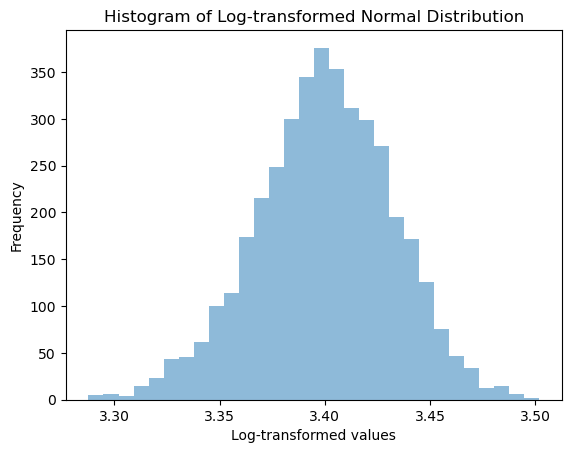

In [30]:
with pm.Model() as model:
    # Define the normal distribution
    normal_dist = pm.Normal('normal_dist', mu=mu, sigma=sig)
    
    # Apply the logarithmic transformation
    log_transform = pm.Deterministic('log_transform', pt.log(normal_dist))
    
    # Sample from the model
    trace = pm.sample(1000, return_inferencedata=False)

# Plot the transformed distribution
plt.hist(trace['log_transform'], bins=30, histtype="stepfilled", alpha=0.5)
plt.xlabel('Log-transformed values')
plt.ylabel('Frequency')
plt.title('Histogram of Log-transformed Normal Distribution')
plt.show()

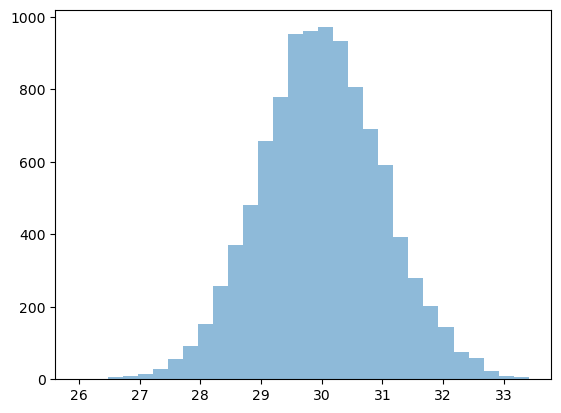

In [6]:
x = pm.draw(pm.Normal.dist(mu=mu, sigma=sig), 10000)
plt.hist(x, bins=30, histtype="stepfilled", alpha=0.5);

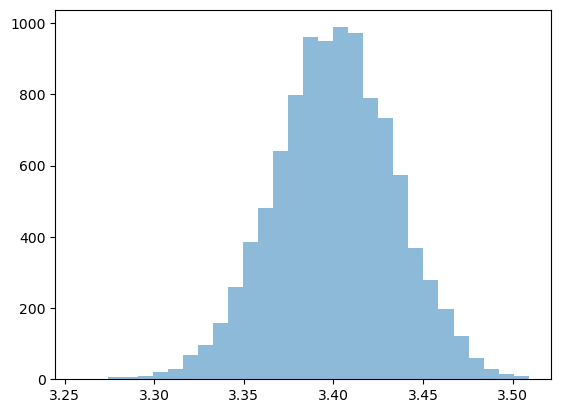

In [7]:
y = np.log(x)
plt.hist(y, bins=30, histtype="stepfilled", alpha=0.5);

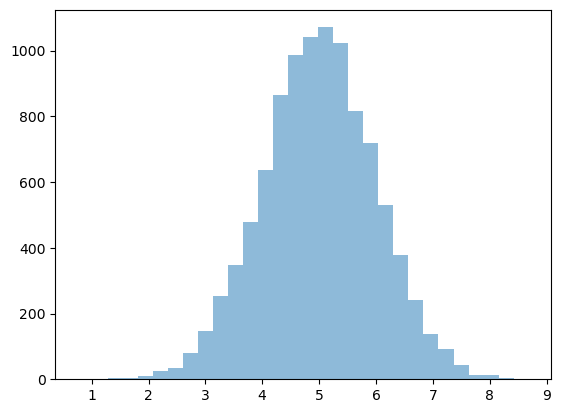

In [8]:
x = pm.draw(pm.Normal.dist(mu=5, sigma=1), 10000)
plt.hist(x, bins=30, histtype="stepfilled", alpha=0.5);

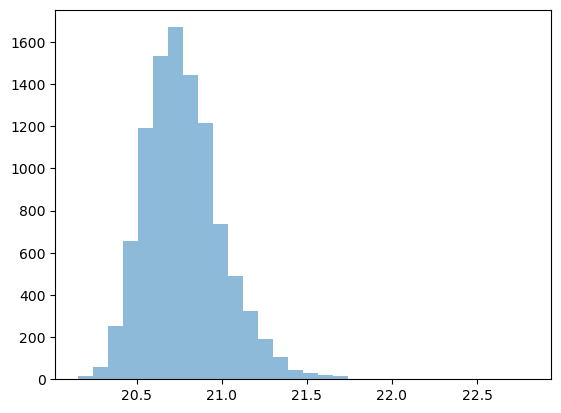

In [9]:
y = 22.5 -2.5*np.log10(x)
plt.hist(y, bins=30, histtype="stepfilled", alpha=0.5);

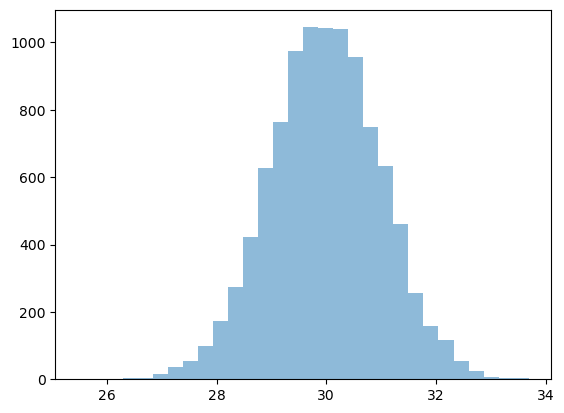

In [10]:
z = pm.draw(pm.TruncatedNormal.dist(mu=mu, sigma=sig, lower=0, upper=float("inf")), 10000)
plt.hist(z, bins=30, histtype="stepfilled", alpha=0.5);

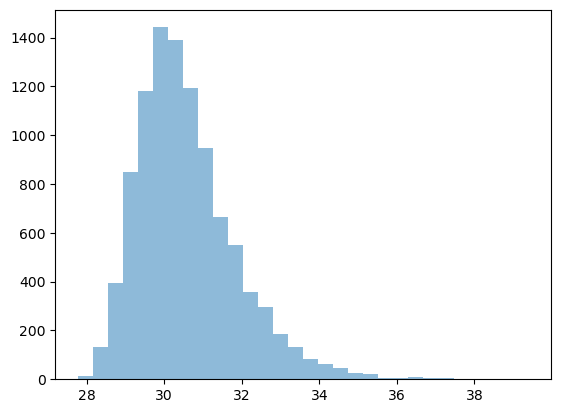

In [11]:
t = pm.draw(pm.Gumbel.dist(mu=mu, beta=sig), 10000)
plt.hist(t, bins=30, histtype="stepfilled", alpha=0.5);

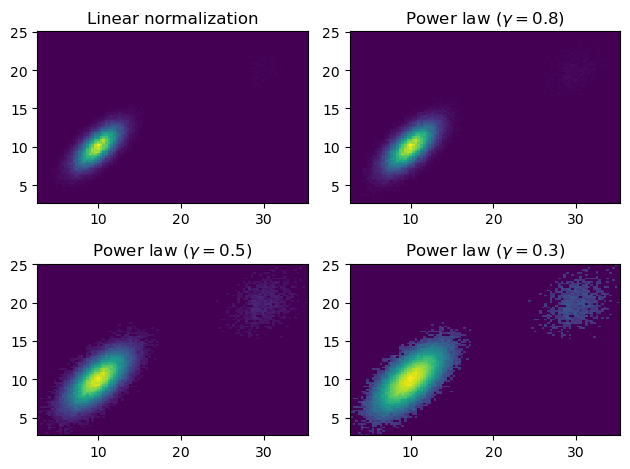

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import multivariate_normal

# Fixing random state for reproducibility.
np.random.seed(19680801)

data = np.vstack([
    multivariate_normal([10, 10], [[3, 2], [2, 3]], size=100000),
    multivariate_normal([30, 20], [[3, 1], [1, 3]], size=1000)
])

gammas = [0.8, 0.5, 0.3]

fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0, 0].set_title('Linear normalization')
axs[0, 0].hist2d(data[:, 0], data[:, 1], bins=100)

for ax, gamma in zip(axs.flat[1:], gammas):
    ax.set_title(r'Power law $(\gamma=%1.1f)$' % gamma)
    ax.hist2d(data[:, 0], data[:, 1], bins=100, norm=mcolors.PowerNorm(gamma))

fig.tight_layout()

plt.show()

<div>
<img src="https://www.cosmos.esa.int/documents/3414525/0/Logo_Gaia_may_23_2022.png/cf6be61e-609e-27dc-3ad6-03ac5209bdc4?t=1653299950248" width="300" align="right"/>    
</div>


# Cone search > Bulk download 

<br />
<br />
<br />
<br />
<br />


**Release number:** 
v1.1 (2022-08-06)


**Applicable Gaia Data Releases:**
Gaia EDR3, Gaia DR3

**Author:**
Héctor Cánovas Cabrera; hector.canovas@esa.int

**Summary:** 

This code computes the list of Gaia (E)DR3 files associated to a circular region in the sky defined by the user. The granularity of this region is set by the [HEALPix](https://healpix.sourceforge.io) level selected.

Input parameters:
* target catalogue (e.g., gaia_source, auxiliary/agn_cross_id, or auxiliary/frame_rotator_source),
* the cone-search parameters (centre and radius), and
* the desired healpix level.

Once the variables above are set the notebook creates a reference file that contains the min/max [HEALPix](https://healpix.sourceforge.io) index (levels: 6,7,8, and 9) encompassed by each gaia_source file available in the (E)DR3 [bulk download directory.](http://cdn.gea.esac.esa.int/Gaia/). The convertion between the different [HEALPix](https://healpix.sourceforge.io) levels is done by means of bit-shifting operations.


**Useful URLs:**

* [Questions or suggestions](https://www.cosmos.esa.int/web/gaia/questions)
* [Tutorials, documentation, and more](https://www.cosmos.esa.int/web/gaia-users/archive)
* [Known issues in the Gaia data](https://www.cosmos.esa.int/web/gaia-users/known-issues)
* [Gaia data credits and acknowledgements](https://www.cosmos.esa.int/web/gaia-users/credits)

In [2]:
import gzip
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from astropy import units as u
from astropy_healpix import HEALPix

## Set input variables

Default input paramers:
* DR3 = True ; Default Value. Set it to False to retrieve EDR3 files
* target_table = 'gaia_source' ; Alternative values: 'Astrophysical_parameters/astrophysical_parameters', 'Variability/vari_cepheid', etc - see all the content in: http://cdn.gea.esac.esa.int/Gaia/gdr3/ & http://cdn.gea.esac.esa.int/Gaia/gedr3/
* Cone-search parameters: radius = 0.5 degrees, centred in the Large Magallanic Cloud (in ICRS coordinates).
* Healpix-level = 6 (choose a larger one to increase granularity, and viceversa).

In [3]:
# Set input parameters below ===========
DR3 = True  # Set it to False to select EDR3
target_table = 'gaia_source'  # Alternative values: 'Astrophysical_parameters/astrophysical_parameters/', etc
hpx_level = 6
lon = 80.894 * u.deg  # Right Ascencion (ICRS)
lat = -69.756 * u.deg  # Declination (ICRS)
radius = 0.5 * u.deg

ROOT = Path(".").resolve().parent
DATA_DIR = ROOT / "data"
output_dir = DATA_DIR / 'raw'

print('Input Variables: ')
print(f'* HEALPix level                      = {hpx_level} ')
print(f'* ICRS longitude (~ Right Ascension) = {lon} ')
print(f'* ICRS latitude  (~ Declination)     = {lat} ')
print(f'* Radius                             = {radius} ')
print()

Input Variables: 
* HEALPix level                      = 6 
* ICRS longitude (~ Right Ascension) = 80.894 deg 
* ICRS latitude  (~ Declination)     = -69.756 deg 
* Radius                             = 0.5 deg 



## Create reference file

In [4]:
gaia_dr_flag = 'DR3' if DR3 else 'EDR3'

print('='*120)
print(f'Preparing selection of Gaia {gaia_dr_flag}: ""{target_table}" files')
print('='*120)

url_prefix      = f'http://cdn.gea.esac.esa.int/Gaia/g{gaia_dr_flag.lower()}/{target_table}/'
md5sum_file_url = url_prefix + '_MD5SUM.txt'
md5sum_file     = pd.read_csv(md5sum_file_url, header=None, sep=r'\s+', names=['md5Sum', 'file'])

if DR3:
    md5sum_file.drop(md5sum_file.tail(1).index,inplace=True) # The last row in the "_MD5SUM.txt" file in the DR3 directories includes the md5Sum value of the _MD5SUM.txt file

md5sum_file

Preparing selection of Gaia DR3: ""gaia_source" files


,md5Sum,file
0,52d800747f32a025bdcf1594bbbad29b,GaiaSource_000000-003111.csv.gz
1,aa91dfad8cc5122f109aacb462fb8304,GaiaSource_003112-005263.csv.gz
2,0ee8a887c3db8cb5110354c42289b0a2,GaiaSource_005264-006601.csv.gz
3,11ced35b2cead1950331222f6c5690f0,GaiaSource_006602-007952.csv.gz
4,b178d83fbe020b1f131c0aedcdc0cd29,GaiaSource_007953-010234.csv.gz
...,...,...
3381,20c69195b88742d586b0227d1831893a,GaiaSource_783518-784479.csv.gz
3382,bf8bf6562d676df85787a23e62a05b79,GaiaSource_784480-784992.csv.gz
3383,158b295db422e9d024b8f6c8429aaa9d,GaiaSource_784993-785417.csv.gz
3384,57c5737e81e2548ff0f1d57d7b667096,GaiaSource_785418-786096.csv.gz


In [5]:
# Extract HEALPix level-8 from file name ======================================
healpix_8_min  = [int(file[file.find('_')+1:file.rfind('-')])     for file in md5sum_file['file']]
healpix_8_max  = [int(file[file.rfind('-')+1:file.rfind('.csv')]) for file in md5sum_file['file']]
reference_file = pd.DataFrame({'file':md5sum_file['file'], 'healpix8_min':healpix_8_min, 'healpix8_max':healpix_8_max}).reset_index(drop=True)

# Compute HEALPix levels 6,7, and 9 ===========================================
reference_file['healpix7_min'] = [inp >> 2 for inp in reference_file['healpix8_min']]
reference_file['healpix7_max'] = [inp >> 2 for inp in reference_file['healpix8_max']]

reference_file['healpix6_min'] = [inp >> 2 for inp in reference_file['healpix7_min']]
reference_file['healpix6_max'] = [inp >> 2 for inp in reference_file['healpix7_max']]

reference_file['healpix9_min'] = [inp << 2       for inp in reference_file['healpix8_min']]
reference_file['healpix9_max'] = [(inp << 2) + 3 for inp in reference_file['healpix8_max']]

# Generate reference file =====================================================
ncols          = ['file', 'healpix6_min', 'healpix6_max', 'healpix7_min', 'healpix7_max', 'healpix8_min', 'healpix8_max', 'healpix9_min', 'healpix9_max']
reference_file = reference_file[ncols]
reference_file

,file,healpix6_min,healpix6_max,healpix7_min,healpix7_max,healpix8_min,healpix8_max,healpix9_min,healpix9_max
0,GaiaSource_000000-003111.csv.gz,0,194,0,777,0,3111,0,12447
1,GaiaSource_003112-005263.csv.gz,194,328,778,1315,3112,5263,12448,21055
2,GaiaSource_005264-006601.csv.gz,329,412,1316,1650,5264,6601,21056,26407
3,GaiaSource_006602-007952.csv.gz,412,497,1650,1988,6602,7952,26408,31811
4,GaiaSource_007953-010234.csv.gz,497,639,1988,2558,7953,10234,31812,40939
...,...,...,...,...,...,...,...,...,...
3381,GaiaSource_783518-784479.csv.gz,48969,49029,195879,196119,783518,784479,3134072,3137919
3382,GaiaSource_784480-784992.csv.gz,49030,49062,196120,196248,784480,784992,3137920,3139971
3383,GaiaSource_784993-785417.csv.gz,49062,49088,196248,196354,784993,785417,3139972,3141671
3384,GaiaSource_785418-786096.csv.gz,49088,49131,196354,196524,785418,786096,3141672,3144387


## Compute Healpix indexes associated to the selected  circular region

In [6]:
print('='*120)
print(f'Computing HEALPix Level {hpx_level} encompasing a Cone Search (Radius, longitude, latitude): {radius.value} {radius.unit},  {lon.value} {lon.unit}, {lat.value} {lat.unit}')
print('='*120)

hp = HEALPix(nside=2**hpx_level, order='nested')
hp_cone_search = hp.cone_search_lonlat(lon, lat, radius=radius)

Computing HEALPix Level 6 encompasing a Cone Search (Radius, longitude, latitude): 0.5 deg,  80.894 deg, -69.756 deg


## Download files

A .txt file with the list of files to be downloaded will be firts created. This file will be read and a secuencial download of all the files listed will start. A progress message will be in the terminal from where this Notebook was launched.

In [7]:
subset = []
for index in reference_file.index:
    row = reference_file.iloc[index]
    hp_min, hp_max = row[f'healpix{hpx_level}_min'], row[f'healpix{hpx_level}_max']
    if np.any(np.logical_and(hp_min <= hp_cone_search, hp_cone_search <= hp_max)):
        subset.append(url_prefix + row['file'])

print('='*120)
print(f'A total of {len(subset)} files for download')
print('='*120)

A total of 8 files for download


In [8]:
import contextlib
from urllib.request import urlopen, urlretrieve

from tqdm import tqdm

print("=" * 120)
print(f"Bulk download files are stored in directory: {output_dir}")
print("=" * 120)


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url: str):
    name = url.strip().split("/")[-1]
    filename = output_dir / name

    if filename.exists():
        statinfo = filename.stat()

        with contextlib.closing(urlopen(url)) as fp:
            headers = fp.info()
            length = int(headers["content-length"])

        if statinfo.st_size == length:
            print(f"Skipping {name}, file already downloaded")
            return
        else:
            print(f"Redownloading {name}")


    with DownloadProgressBar(
        unit="B",
        unit_scale=True,
        miniters=1,
        desc=name,
    ) as bar:
        urlretrieve(url, filename=filename, reporthook=bar.update_to)


for url in subset:
    download_url(url)


Bulk download files are stored in directory: C:\Users\isaacm\myCode\estimacion-paralajes\data\raw
Skipping GaiaSource_529516-529538.csv.gz, file already downloaded
Skipping GaiaSource_529539-529547.csv.gz, file already downloaded
Skipping GaiaSource_529548-529556.csv.gz, file already downloaded
Skipping GaiaSource_529557-529566.csv.gz, file already downloaded
Skipping GaiaSource_529567-529575.csv.gz, file already downloaded
Skipping GaiaSource_529576-529584.csv.gz, file already downloaded
Skipping GaiaSource_529585-529596.csv.gz, file already downloaded
Skipping GaiaSource_529597-529615.csv.gz, file already downloaded


In [9]:
fields = OrderedDict([
    ('source_id', np.int64),
    ('ra', np.float64),
    ('ra_error', np.float64),
    ('dec', np.float64),
    ('dec_error', np.float64),
    ('parallax', np.float64),
    ('parallax_error', np.float64),
    ('phot_g_n_obs', np.int32),
    ('phot_g_mean_flux', np.float64),
    ('phot_g_mean_flux_error', np.float64),
    ('phot_g_mean_mag', np.float64),
    ('phot_bp_n_obs', np.int32),
    ('phot_bp_mean_flux', np.float64),
    ('phot_bp_mean_flux_error', np.float64),
    ('phot_bp_mean_mag', np.float64),
    ('phot_rp_n_obs', np.int32),
    ('phot_rp_mean_flux', np.float64),
    ('phot_rp_mean_flux_error', np.float64),
    ('phot_rp_mean_mag', np.float64),
])

In [10]:
import io
from astropy.table import Table


def extract_header_table(filename, **kwargs):
    with gzip.open(filename, mode="rt", newline="") as file, io.BytesIO() as virtual:
        for line in file:
            virtual.write(line.encode())
            if not line.startswith("#"):
                break
        virtual.seek(0)
        return Table.read(
            virtual,
            format="ascii.ecsv",
            **kwargs,
        )


extract_header_table(
    next(output_dir.glob("*.csv.gz")),
    include_names=fields,
    fill_values=("null", "0"),
)

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag
,deg,mas,deg,mas,mas,mas,,'electron'.s**-1,'electron'.s**-1,mag,,'electron'.s**-1,'electron'.s**-1,mag,,'electron'.s**-1,'electron'.s**-1,mag
int64,float64,float32,float64,float32,float64,float32,int16,float64,float32,float32,int16,float64,float32,float32,int16,float64,float32,float32


In [11]:
df = pd.concat(
    pd.read_csv(
        path,
        comment="#",
        index_col="source_id",
        usecols=fields,
        dtype=fields,
    ) for path in output_dir.glob("*.csv.gz")
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4250639 entries, 4657671992749548032 to 4658551572038462208
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   ra                       float64
 1   ra_error                 float64
 2   dec                      float64
 3   dec_error                float64
 4   parallax                 float64
 5   parallax_error           float64
 6   phot_g_n_obs             int32  
 7   phot_g_mean_flux         float64
 8   phot_g_mean_flux_error   float64
 9   phot_g_mean_mag          float64
 10  phot_bp_n_obs            int32  
 11  phot_bp_mean_flux        float64
 12  phot_bp_mean_flux_error  float64
 13  phot_bp_mean_mag         float64
 14  phot_rp_n_obs            int32  
 15  phot_rp_mean_flux        float64
 16  phot_rp_mean_flux_error  float64
 17  phot_rp_mean_mag         float64
dtypes: float64(15), int32(3)
memory usage: 567.5 MB


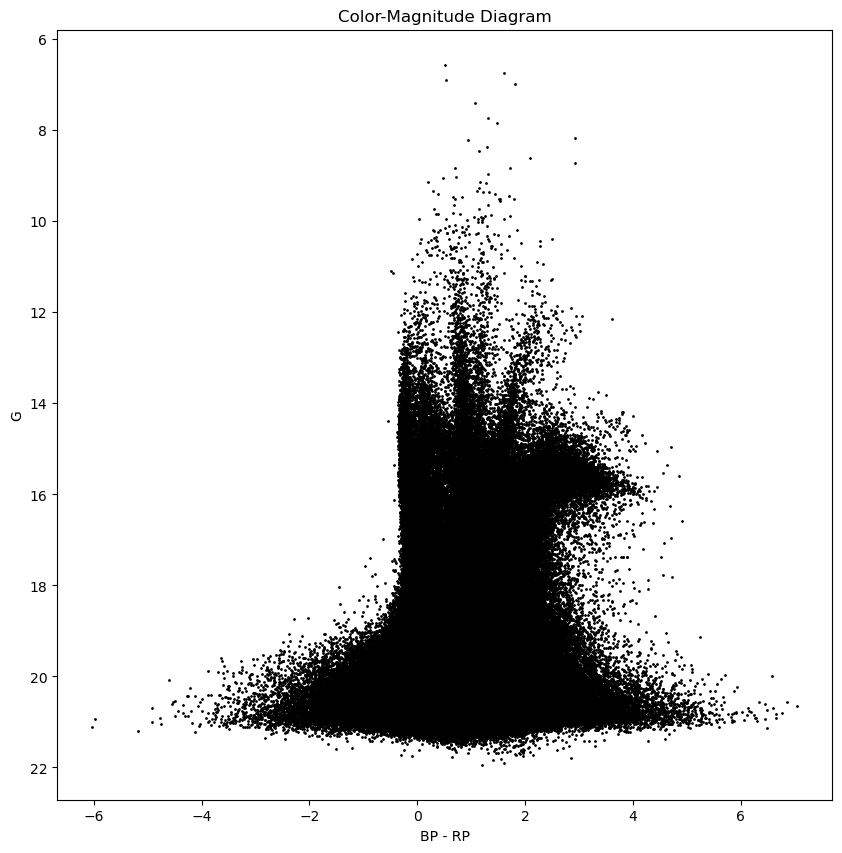

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], s=1, c='black')
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Color-Magnitude Diagram')
plt.show()